In [1]:
from ROOT import TFile,TTree,TH1D,TCanvas,TGraphErrors,TF1,gROOT,kTRUE,gStyle,gPad,TH1Editor,TF1Convolution
import os, sys, shutil
import numpy as np
import numpy

from Core.Utils.tdrStyle import setTDRStyle
from DarkZ.Script.Fitting.Mass_Collection_cls import HistCollection
from DarkZ.Script.Fitting.Functions_Navigation import make_dir_copy_file
from DarkZ.Script.Fitting.Fns_Math import lorentzian

Welcome to JupyROOT 6.10/09


## User Input

In [2]:
class MyHist:
    def __init__(self,fs,mass,year):
        self.fs = fs
        self.mass = mass
        self.year = year
        
        self.best_fit_sigma = -1
        self.best_fit_sigma_err = -1
        self.best_fit_rel_sigma = -1
        self.best_fit_rel_sigma_err = -1
        
        self.hist = None
        
        self.hist_fit_list = []
        self.fit_list = []
        self.canvas_list = []
        
        self.fit_const_list = []
        self.fit_const_err_list = []
        self.fit_mean_list = []
        self.fit_mean_err_list = []
        self.fit_sigma_list = []
        self.fit_sigma_err_list = []
        self.fit_rel_sigma_list = []
        self.fit_rel_sigma_err_list = []
        
        self.n_stdev_list = []
        self.red_chi2_list = []
        self.n_dof_list = []
        
        
    def fit_with_gaus(self, n_stdev_list, draw=False, fit_around_mean=False):
        """
        FIXME
        fit_with_gaus(self, n_stdev_list, draw=False, fit_around_mean=False)

        Fits a single histogram (self.hist) with various gaus fits, over different sigma ranges.
            Fit range: mu +- N*sigma
                mu = mean of hist
                sigma = stdev of hist
                N = number of sigmas, taken from n_stdev_list        

        # Perform gaus fits over the range: hist_mean +- N*hist_sigma,
        # where X is some number of hist_sigmas. 
        Fit can be done centered at the mean (fit_around_mean=True) or around the peak 
        of the histogram (fit_around_mean=False).

        Returns:
            hist_list, fit_list, canvas_list
        """
        hist_list_tmp = []
        fit_list = []
        canvas_list = []
        n_dof_list = []

        for nstdev in n_stdev_list:

            canvas_list.append(TCanvas())
            hist_list_tmp.append( self.hist.Clone() )
            h_tmp = hist_list_tmp[-1]
            h_tmp.mass = self.mass
            h_tmp.n_sigmas = nstdev
            h_tmp.mean = h_tmp.GetMean()
            h_tmp.stdev = h_tmp.GetStdDev()

            h_tmp.bin_at_max = h_tmp.GetMaximumBin()
            h_tmp.most_prob_val = h_tmp.GetXaxis().GetBinCenter(h_tmp.bin_at_max)

            if (fit_around_mean):
                center = mean
                center_str = "mean"
    #             print "Fitting is centered on the MEAN."
            else:
                # Fit around the peak instead.
                center = h_tmp.most_prob_val
                center_str = "most_prob_val"
    #             print "Fitting is centered on the MOST PROBABLE VALUE (peak)."
            fit_x_min = center - nstdev*h_tmp.stdev
            fit_x_max = center + nstdev*h_tmp.stdev
            fit_list.append( TF1("fit1","gaus",fit_x_min,fit_x_max) )
            fit_tmp = fit_list[-1]

            # Do the fit.
            h_tmp.params = h_tmp.Fit(fit_tmp,"SRQ")  # S=store_result, R=ranged_fit, Q=quiet 
            
            # Get parameters.
            params = h_tmp.params
            
            h_tmp.fit_const = params.Parameter(0) 
            h_tmp.fit_const_err = params.ParError(0)
            h_tmp.fit_mean = params.Parameter(1)
            h_tmp.fit_mean_err = params.ParError(1)
            h_tmp.fit_sigma = params.Parameter(2)
            h_tmp.fit_sigma_err = params.ParError(2)            
            h_tmp.chi2 = fit_tmp.GetChisquare()  # This returns TOTAL chi^2, not reduced!
            h_tmp.n_dof = fit_tmp.GetNDF()
            
            # Since I'm storing each h_tmp in a hist_fit_list, 
            # I probably don't need these lists below.
            self.fit_const_list.append( h_tmp.fit_const )
            self.fit_const_err_list.append( h_tmp.fit_const_err )
            self.fit_mean_list.append( h_tmp.fit_mean )
            self.fit_mean_err_list.append( h_tmp.fit_mean_err ) 
            self.fit_sigma_list.append( h_tmp.fit_sigma )
            self.fit_sigma_err_list.append( h_tmp.fit_sigma_err )
            self.fit_rel_sigma_list.append( h_tmp.fit_sigma/float(h_tmp.mass) )
            self.fit_rel_sigma_err_list.append( h_tmp.fit_sigma_err/float(h_tmp.mass) )
            self.n_dof_list.append( h_tmp.n_dof )
            
            try:
                h_tmp.reduced_chi2 = h_tmp.chi2/float(h_tmp.n_dof)
            except ZeroDivisionError:
                h_tmp.reduced_chi2 = np.inf
            self.red_chi2_list.append( h_tmp.reduced_chi2 )
            
            if not (draw):
                gROOT.SetBatch(kTRUE)  # Prevent ROOT from drawing plots to screen.
            gStyle.SetOptFit(1111)
#             gStyle.SetStatX(-0.1)
#             gStyle.SetStatY
            h_tmp.SetXTitle("m_{X} [GeV]")
            h_tmp.SetYTitle( "Events / [%.3f GeV]" % h_tmp.GetBinWidth(1) )  # Not underflow bin.

            extra_title = "Fit range: [%s #pm %.2f*sigma]" % (center_str,nstdev)
            if h_tmp.GetName() in ["mZ2_4e","mZ2_2mu2e"]:
                h_tmp.SetTitle("X #rightarrow e^{-}e^{+}, " + extra_title)
            else:
                h_tmp.SetTitle("X #rightarrow #mu^{-}#mu^{+}, " + extra_title)

            h_tmp.Draw('hist e1')
            fit_tmp.Draw("same")
            canvas_list[-1].Update()
            canvas_list[-1].Draw()
            # Done with this one fit.
                
        # Save all info in object.
        self.hist_fit_list = hist_list_tmp
        self.fit_list = fit_list
        self.canvas_list = canvas_list
        self.n_stdev_list = n_stdev_list
#         return hist_list, fit_list, canvas_list
    
    def save_plots(self,outpath):
        """
        save_plots(self,outpath)
        
        Save the drawn canvases to some directory path (outpath).
        
        Parameters
        ----------
        outpath : str
                  Path to store drawn canvases, usually tier2.ihepa.ufl.edu/~...
     
        Returns
        -------
        Nothing, technically. It just saves the canvases.
        """
        stdev_ls = self.n_stdev_list
        canv_ls = self.canvas_list
        
        # Make sure dir to store plots exists.
        year_ = str(self.year)
        fs_ = str(self.fs)
        mass_ = str(self.mass)
        newdir = "%s/%s/%sGeV/" % (year_,fs_,mass_)  # Trailing underscore used to avoid naming conflicts.
        fullpath_newdir = os.path.join(outpath,newdir)
        make_dir_copy_file(fullpath_phpfile,fullpath_newdir)
        
        for count,stdev in enumerate(stdev_ls):
            plot_name = newdir.replace("/","_") + str(stdev).replace(".","p") + "sigmas"
            canv_ls[count].SaveAs(fullpath_newdir + plot_name + ".png")
            canv_ls[count].SaveAs(fullpath_newdir + plot_name + ".pdf")
                            
    def print_fit_info(self):
        """print_fit_info(self)"""
        
        print "fit_mean\tfit_sigma\tchi^2/n_dof\tn_dof\t+-N*hist_sigmas"

        for h in self.hist_fit_list:
            mean = h.fit_mean
            sigma = h.fit_sigma
            red_chi2 = h.reduced_chi2
            n_dof = h.n_dof
            n_sigmas = h.n_sigmas

    #         print "Fit Parameters:"
            print "%.4f\t\t%.4f\t\t%.4f\t\t%d\t%.2f" % (mean,sigma,red_chi2,n_dof,n_sigmas)
        
    def get_best_fit_sigma(self,verbose=False):
        """
        
        Store the sigma value, as the average of all sigmas, weighted by their chi^2.
        The chi^2 values are weighted using a Lorentzian function peaked at 1.
        
        Parameters
        ----------
        """
        red_chi2_list = self.red_chi2_list
        sigma_list = self.fit_sigma_list

        # Normalize the reduced chi^2 values based on how close they are to 1.
        norm_weights = lorentzian(red_chi2_list,1,0.05)
        best_calc_sigma = np.average(sigma_list,weights=norm_weights)
        
        # Use the calculated sigma above to find which actual best_fit_sigma value was closest.
        best_sig = min(self.fit_sigma_list, key = lambda x: abs(x-best_calc_sigma))
        
        # Find the corresponding best values.
        best_sig_index = self.fit_sigma_list.index(best_sig)
        best_sig_err = self.fit_sigma_err_list[best_sig_index]
        best_r_chi2 = self.red_chi2_list[best_sig_index]
        best_n_stdev = self.n_stdev_list[best_sig_index]
        
        best_rel_sig = best_sig/float(self.mass)
        best_rel_sig_err = best_sig_err/float(self.mass)
        
        # Save values.
        self.best_fit_sigma = best_sig
        self.best_fit_sigma_err = best_sig_err
        self.best_fit_rel_sigma = best_rel_sig
        self.best_fit_rel_sigma_err = best_rel_sig_err
        self.best_red_chi2 = best_r_chi2
        self.best_n_stdev = best_n_stdev
        
        if (verbose):
            print "Best calculated sigma:\t\t\t",best_calc_sigma
            print "Best fit sigma matched:\t\t\t",best_sig
            print "Best fit sigma index is:\t\t",best_sig_index
            print "Best fit sigma_err found:\t\t",best_sig_err
            print "Best fit rel_sigma of:\t\t\t",best_rel_sig
            print "Best fit rel_sigma_err of:\t\t",best_rel_sig_err,"\n"

       
    # chi2_list = [hist.reduced_chi2 for hist in hist_list]
    # best_chi2 = min(chi2_list)
    # best_index = chi2_list.index(best_chi2)

In [3]:
#-----------------------#
#----- Config File -----#
#-----------------------#
# mass_list = [1,2,3,4,7,15,20,25,30,35]   # Official HZZd samples
mass_list = [1,2]
year = "2016"
# fs_list = ["4e"]
fs_list = ["4e","4mu","2e2mu","2mu2e"]
n_stdev_list = [x/4. for x in range(1,9)]  # Make whole range of n_stdev for fitting.
# n_stdev_list = [x/4. for x in range(1,21)]  # Make whole range of n_stdev for fitting.

graph_title = "Relative_Mass_Resolution_vs_mZ2_Official Samples"

# NOTES "__massval__" gets substituted out later.
infile_template = "/raid/raid7/rosedj1/Higgs/DarkZ/DarkPhotonSR/DataMCDistributions/HToZZd_Run2016_mXtoll_gausfit/HZZd_M__massval__/DataMCDistribution.root"
outpath_plots = "/home/rosedj1/public_html/Higgs/DarkZ/DarkPhotonSR/HZZd4l_mXtoll_gausfit_officialsamples/"
fullpath_phpfile = "/home/rosedj1/index.php"

Opening file:
/raid/raid7/rosedj1/Higgs/DarkZ/DarkPhotonSR/DataMCDistributions/HToZZd_Run2016_mXtoll_gausfit/HZZd_M1/DataMCDistribution.root
fit_mean	fit_sigma	chi^2/n_dof	n_dof	+-N*hist_sigmas
37.4826		2.7378		0.4094		3	0.25
36.8748		5.7396		0.1456		9	0.50
35.9482		7.8464		0.1297		14	0.75
35.0906		11.3155		0.1460		16	1.00
35.0906		11.3155		0.1460		16	1.25
33.5972		24.4468		0.1386		17	1.50
28.7313		54.2853		0.1097		22	1.75
18.8834		63.8531		0.1093		26	2.00
Best calculated sigma:			19.6584070108
Best fit sigma matched:			24.4468181778
Best fit sigma index is:		5
Best fit sigma_err found:		21.6302765961
Best fit rel_sigma of:			24.4468181778
Best fit rel_sigma_err of:		21.6302765961 

fit_mean	fit_sigma	chi^2/n_dof	n_dof	+-N*hist_sigmas
43.4777		10.7923		0.3130		12	0.25
48.1163		22.6926		0.2228		29	0.50
57.7126		34.8122		0.2544		44	0.75
45.5919		40.0071		0.2485		53	1.00
49.0450		42.7018		0.2392		57	1.25
61.7440		48.0031		0.2288		63	1.50
50.4841		55.3736		0.2387		69	1.75
48.9427		57.4110	

Info in <TCanvas::Print>: png file /home/rosedj1/public_html/Higgs/DarkZ/DarkPhotonSR/HZZd4l_mXtoll_gausfit_officialsamples/2016/4e/1GeV/2016_4e_1GeV_0p25sigmas.png has been created
Info in <TCanvas::Print>: pdf file /home/rosedj1/public_html/Higgs/DarkZ/DarkPhotonSR/HZZd4l_mXtoll_gausfit_officialsamples/2016/4e/1GeV/2016_4e_1GeV_0p25sigmas.pdf has been created
Info in <TCanvas::Print>: png file /home/rosedj1/public_html/Higgs/DarkZ/DarkPhotonSR/HZZd4l_mXtoll_gausfit_officialsamples/2016/4e/1GeV/2016_4e_1GeV_0p5sigmas.png has been created
Info in <TCanvas::Print>: pdf file /home/rosedj1/public_html/Higgs/DarkZ/DarkPhotonSR/HZZd4l_mXtoll_gausfit_officialsamples/2016/4e/1GeV/2016_4e_1GeV_0p5sigmas.pdf has been created
Info in <TCanvas::Print>: png file /home/rosedj1/public_html/Higgs/DarkZ/DarkPhotonSR/HZZd4l_mXtoll_gausfit_officialsamples/2016/4e/1GeV/2016_4e_1GeV_0p75sigmas.png has been created
Info in <TCanvas::Print>: pdf file /home/rosedj1/public_html/Higgs/DarkZ/DarkPhotonSR/HZZd4l

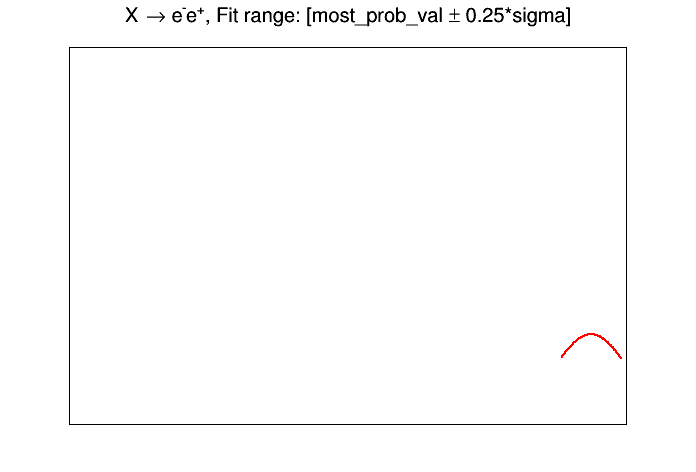

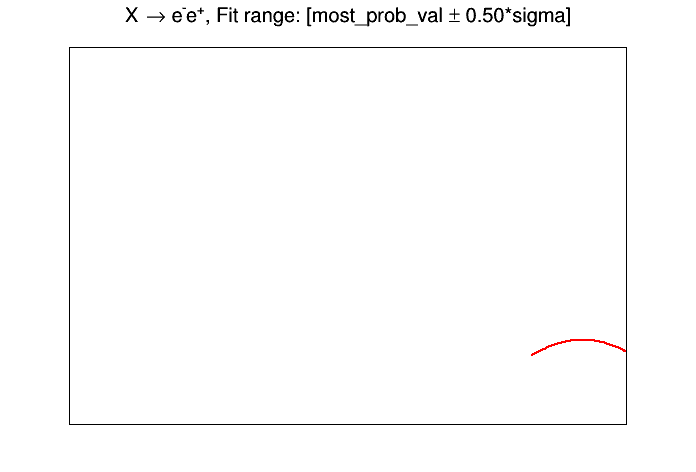

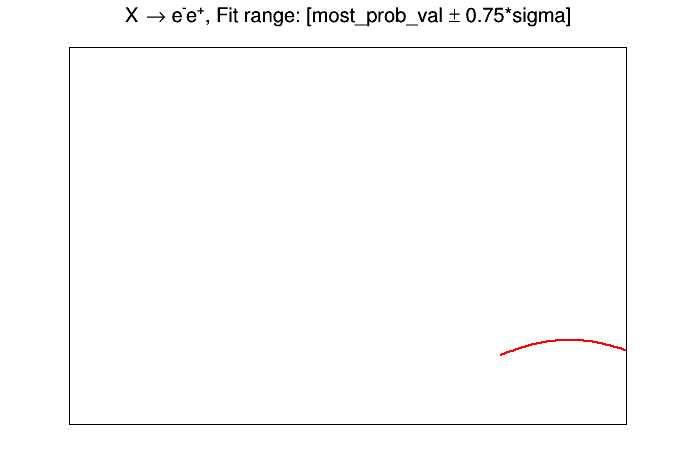

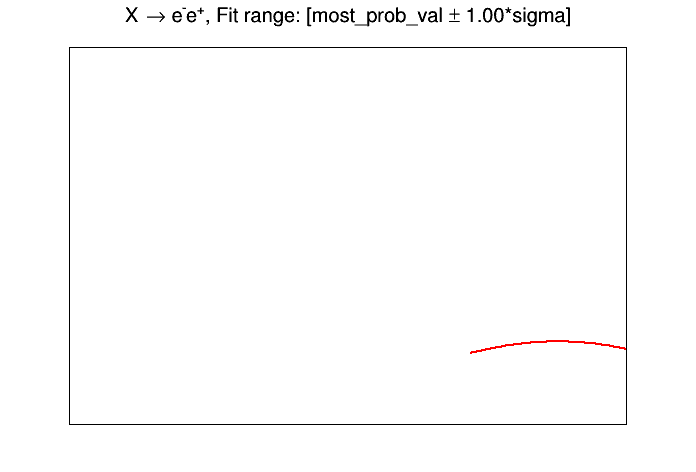

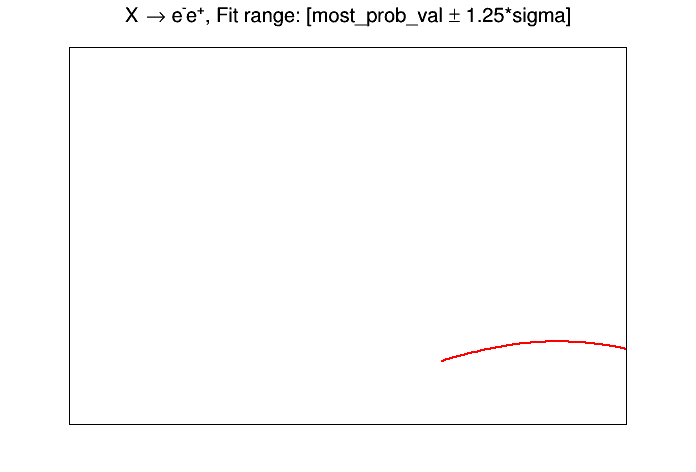

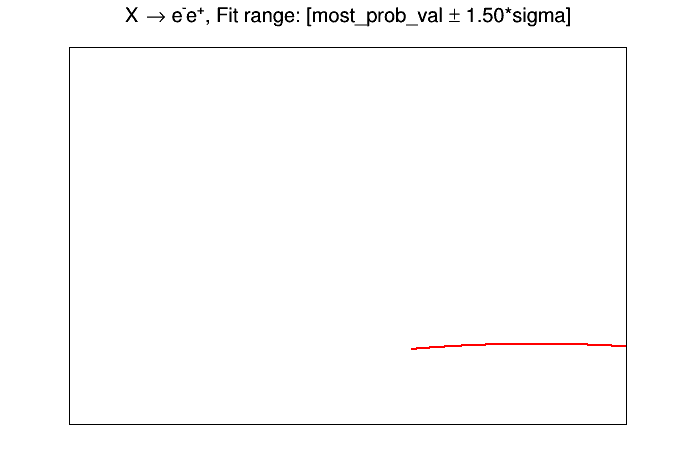

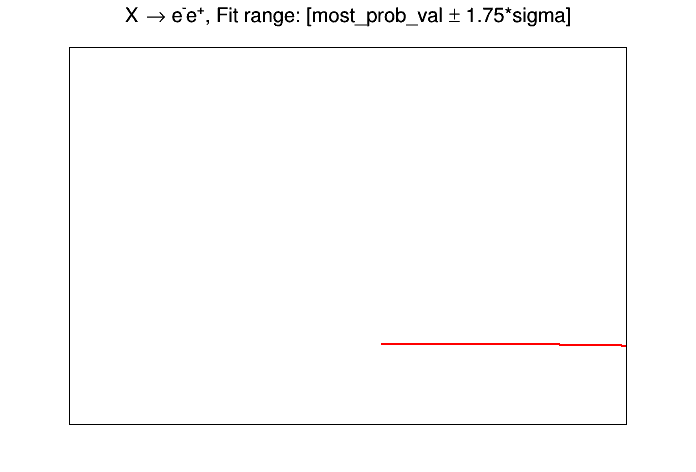

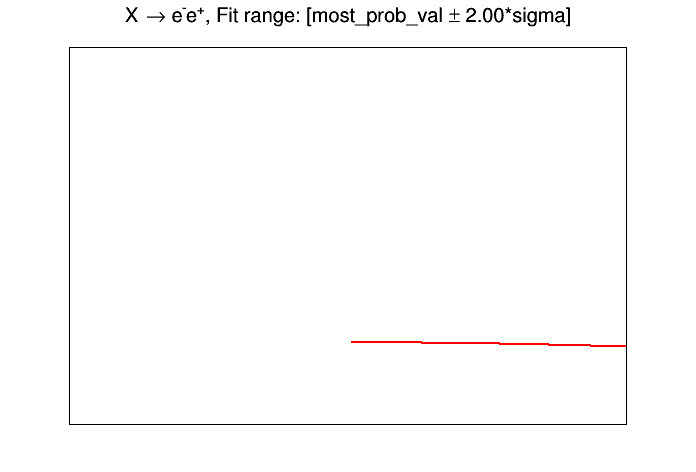

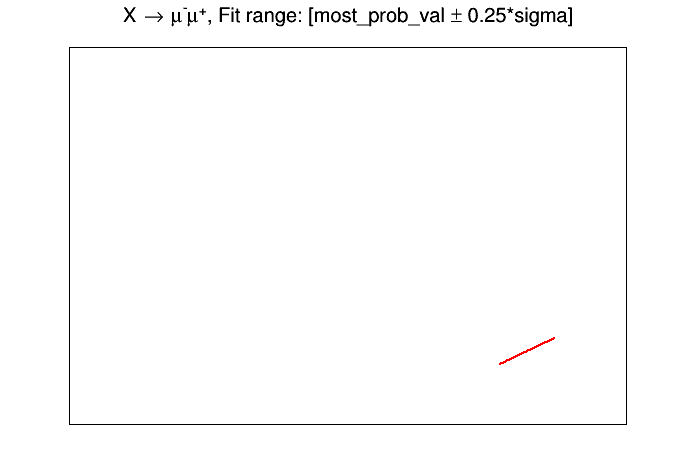

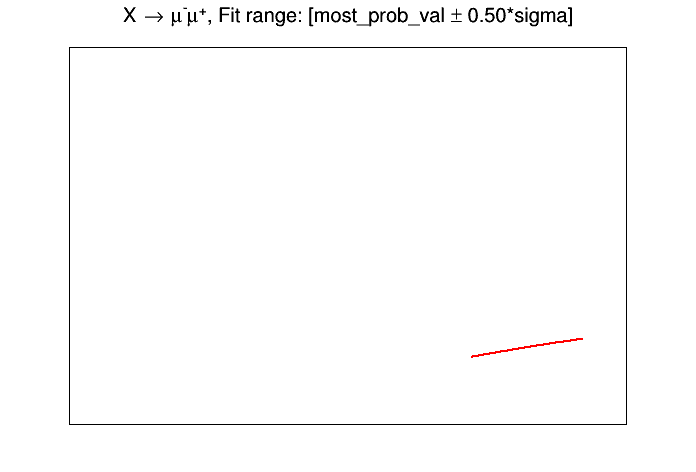

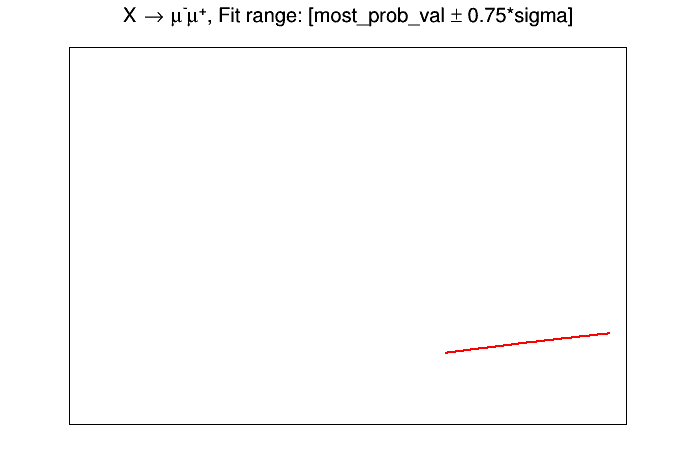

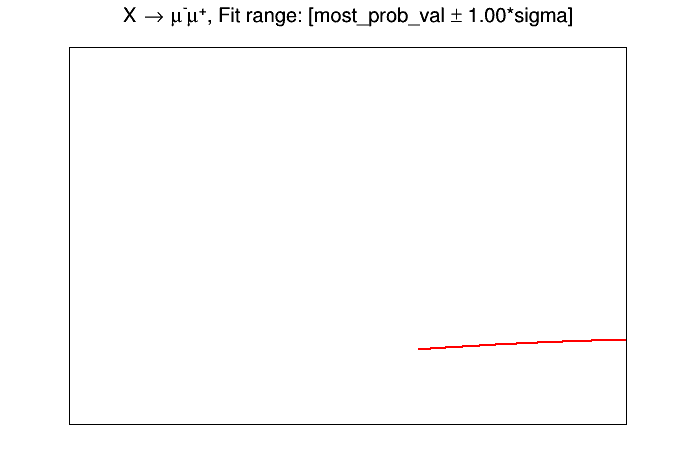

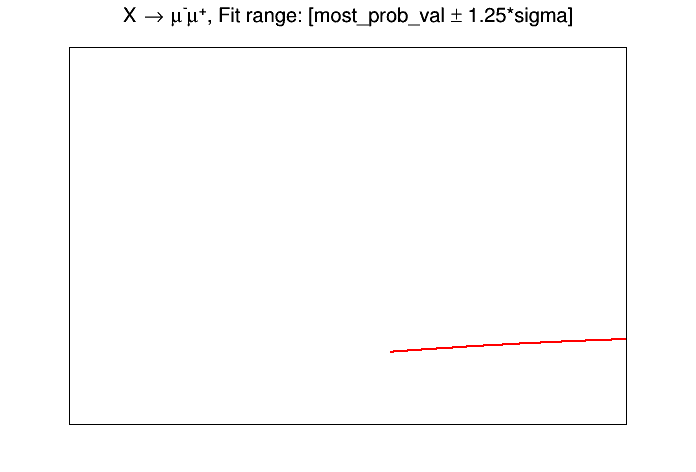

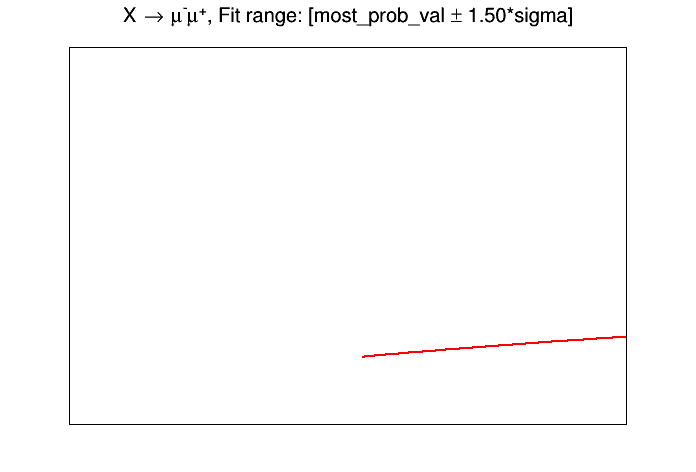

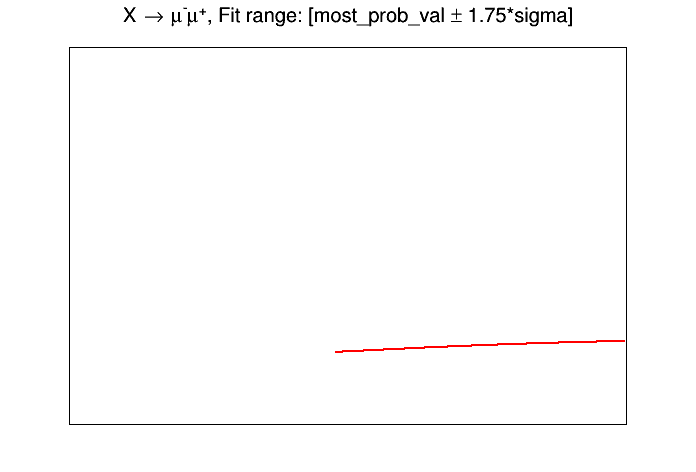

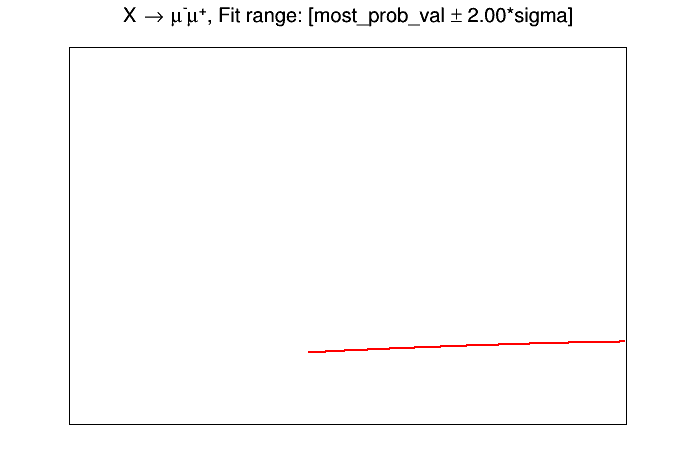

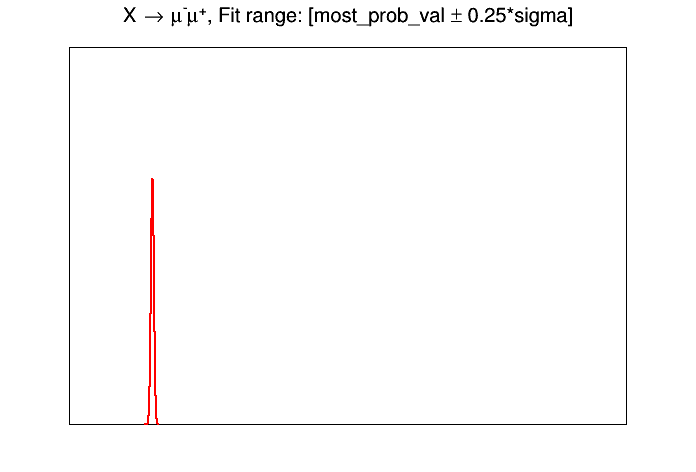

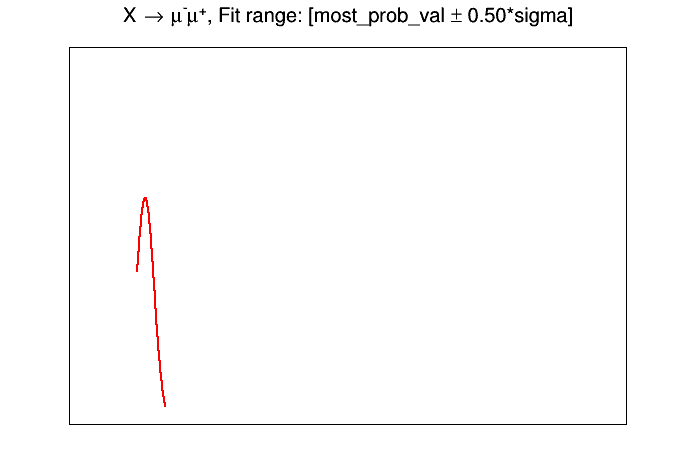

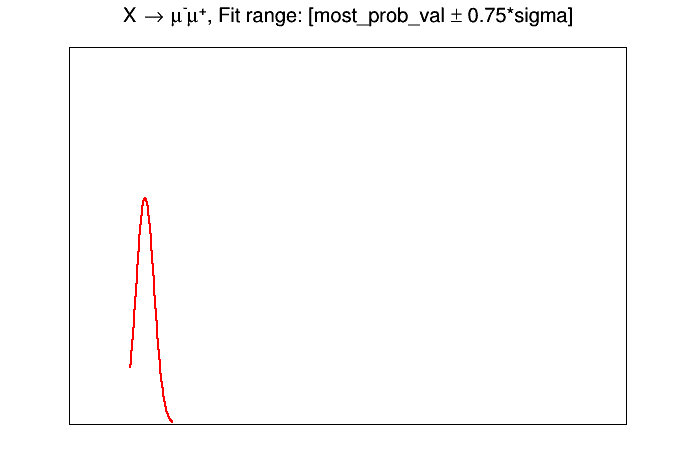

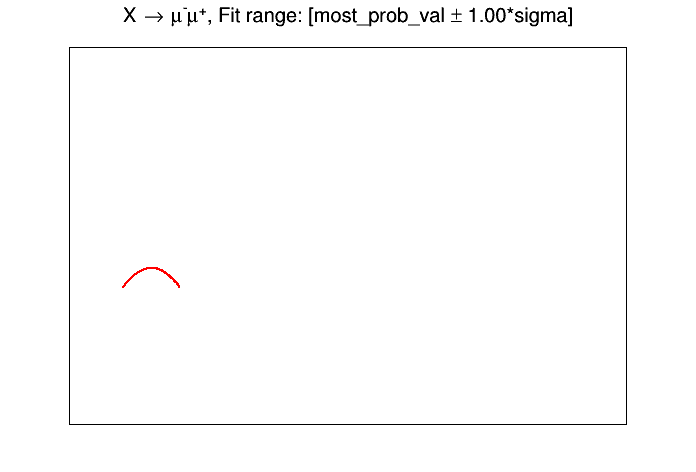

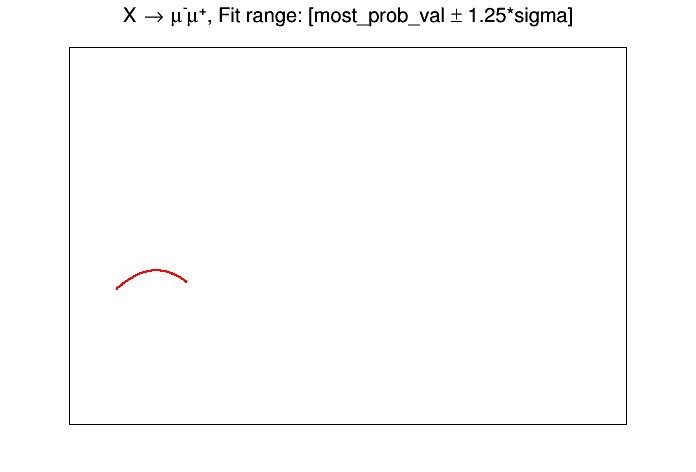

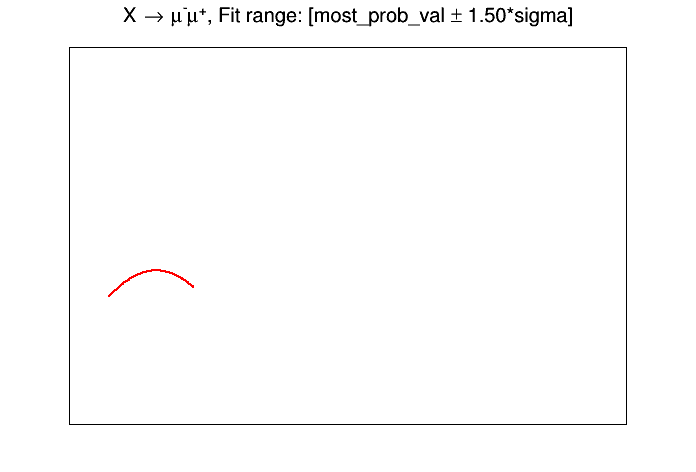

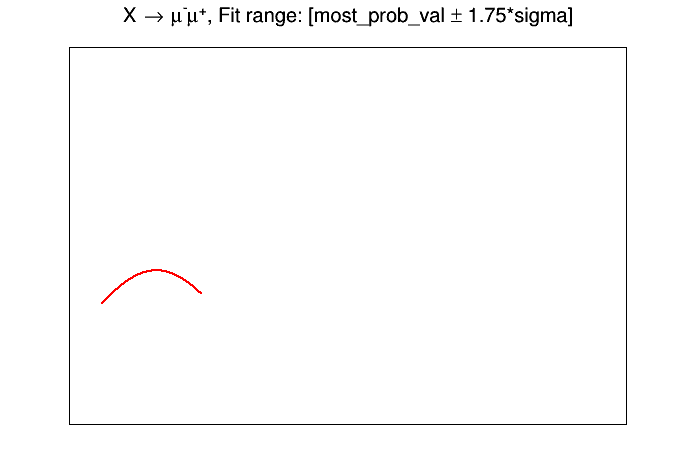

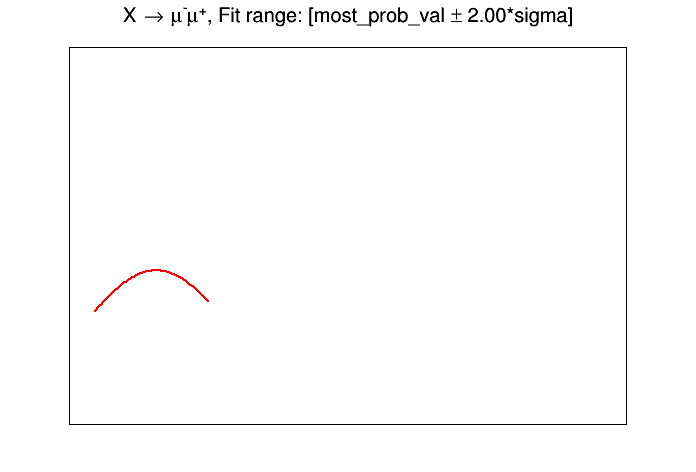

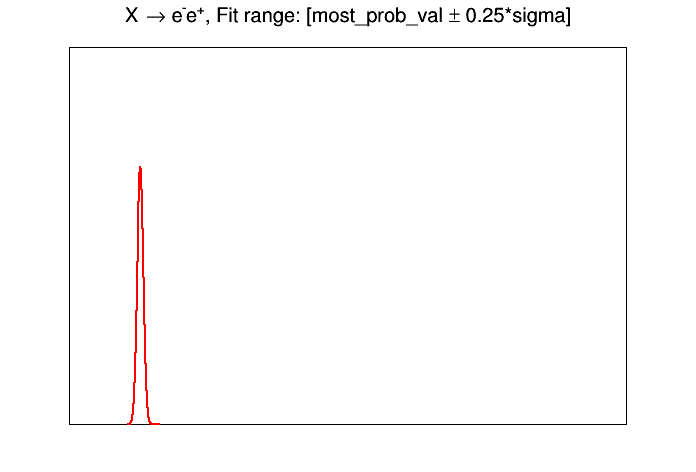

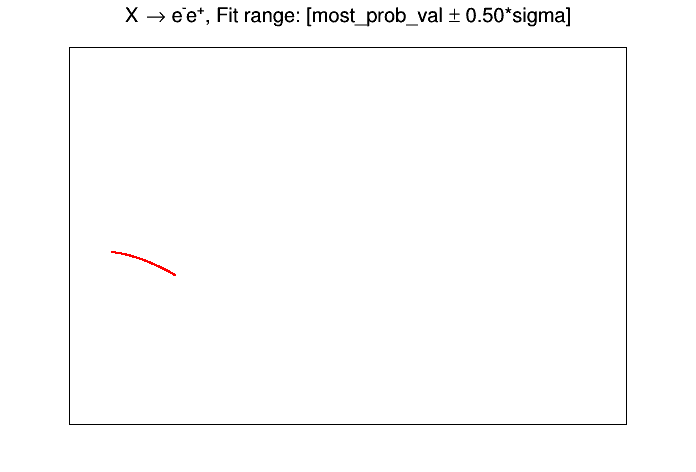

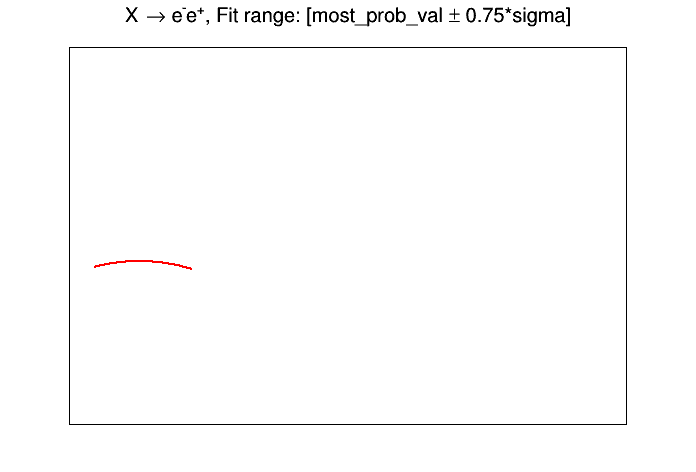

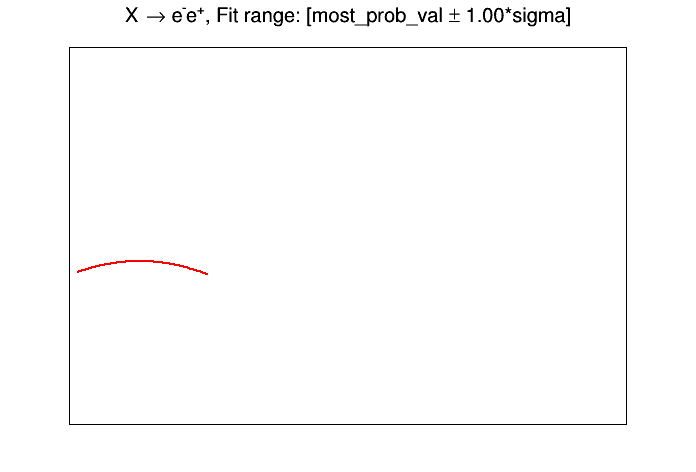

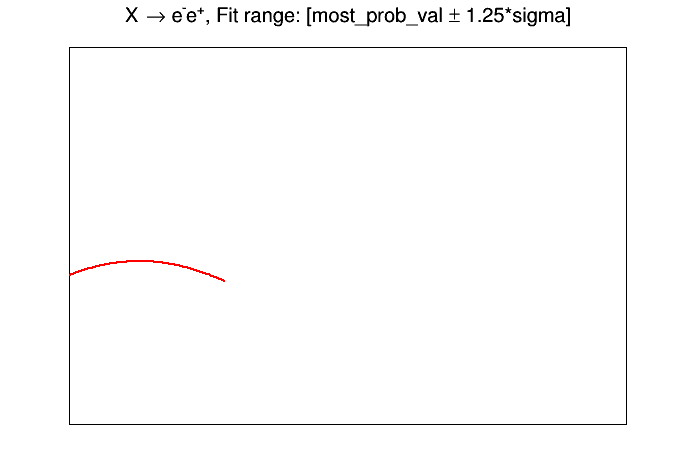

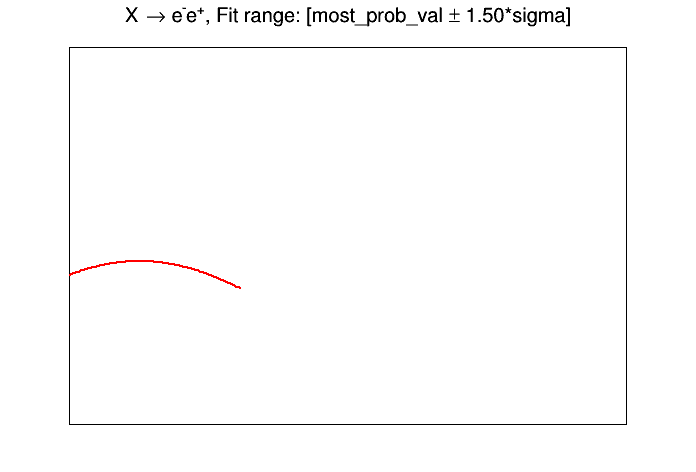

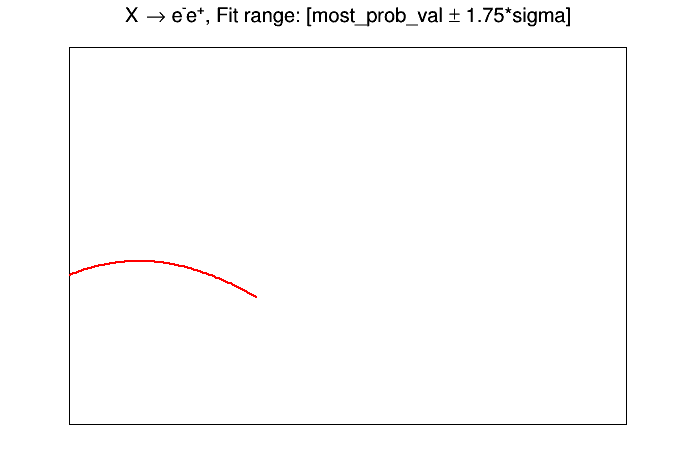

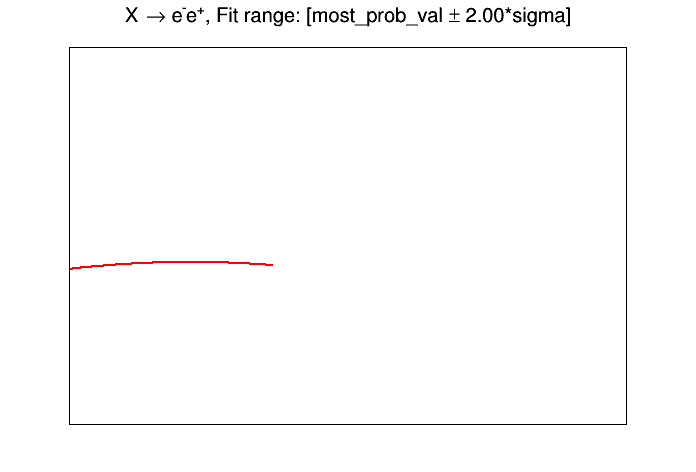

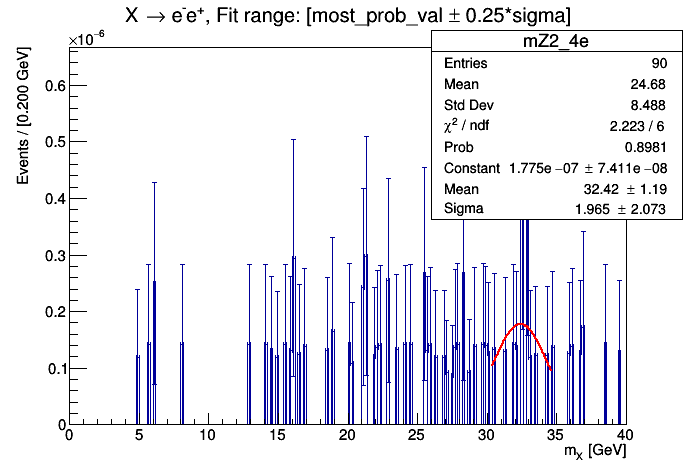

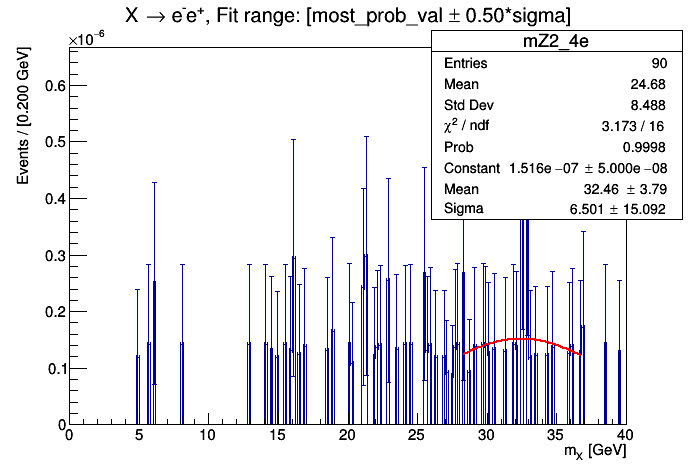

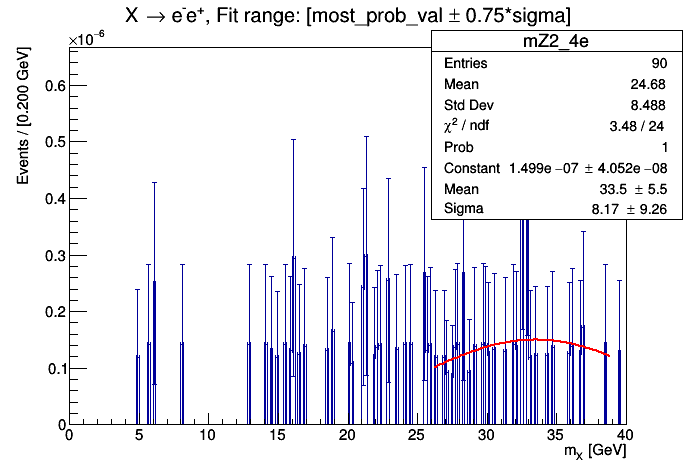

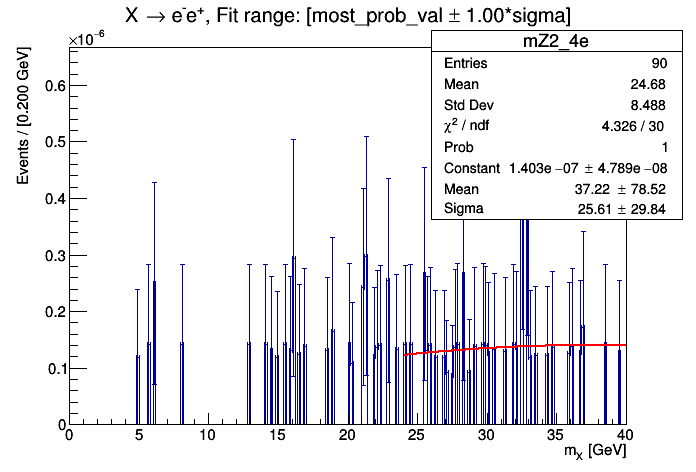

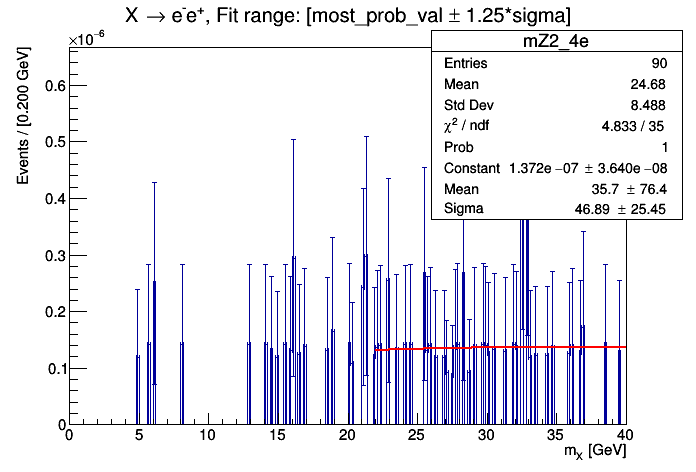

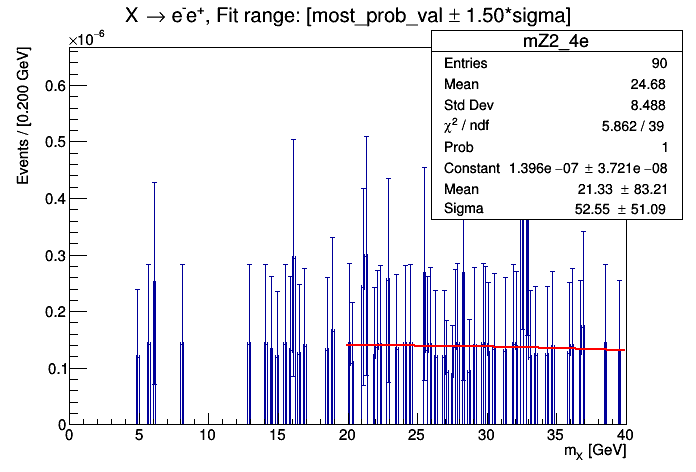

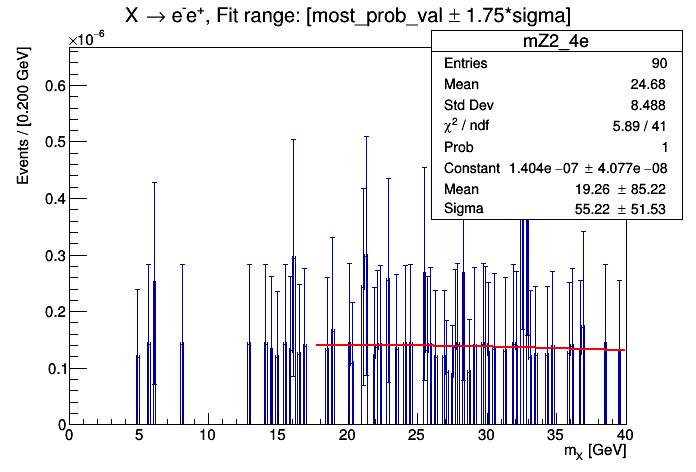

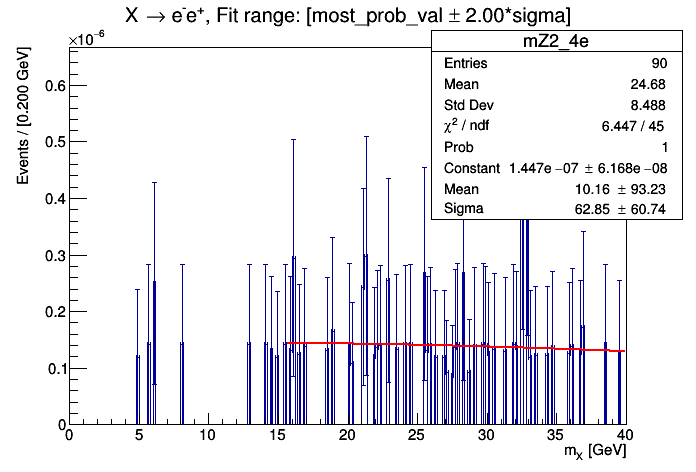

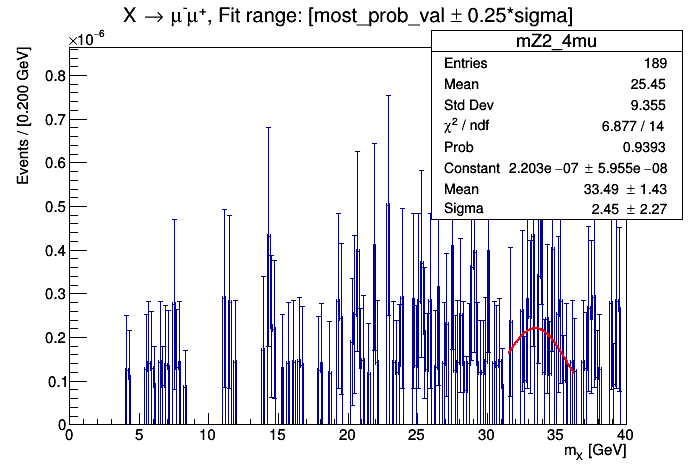

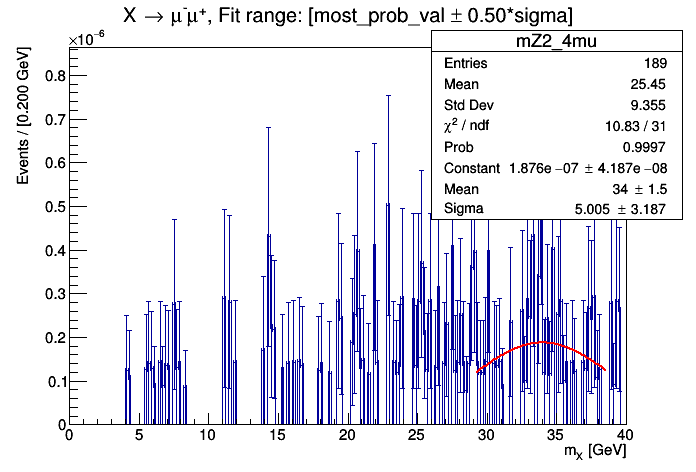

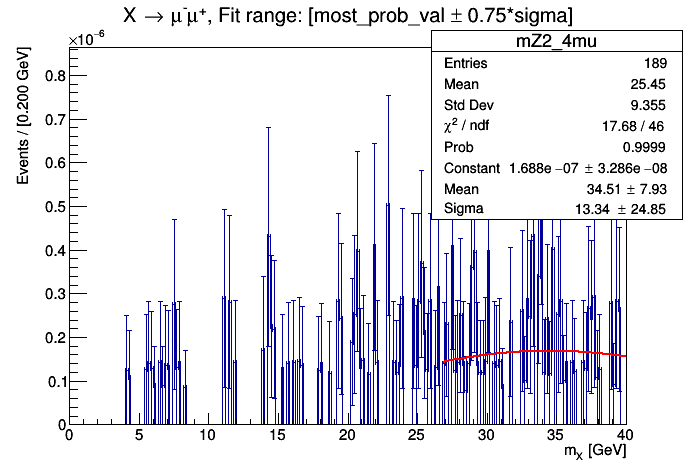

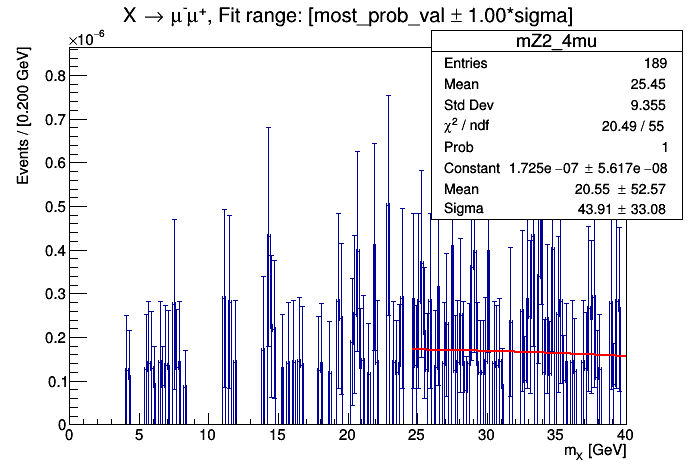

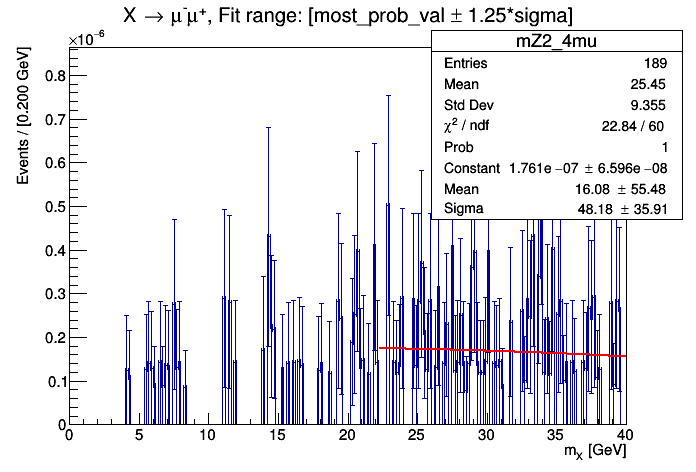

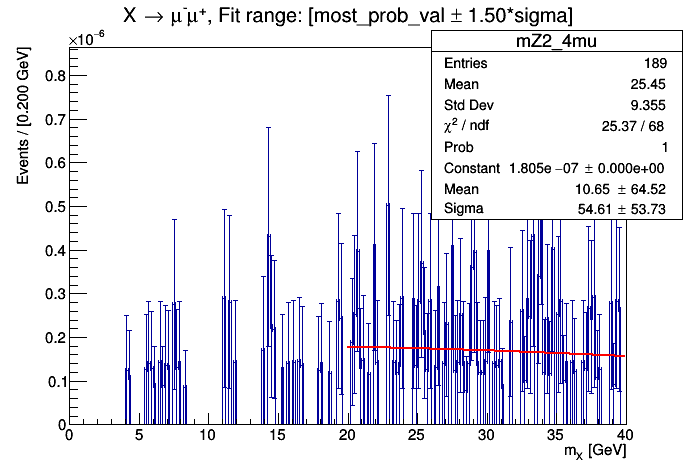

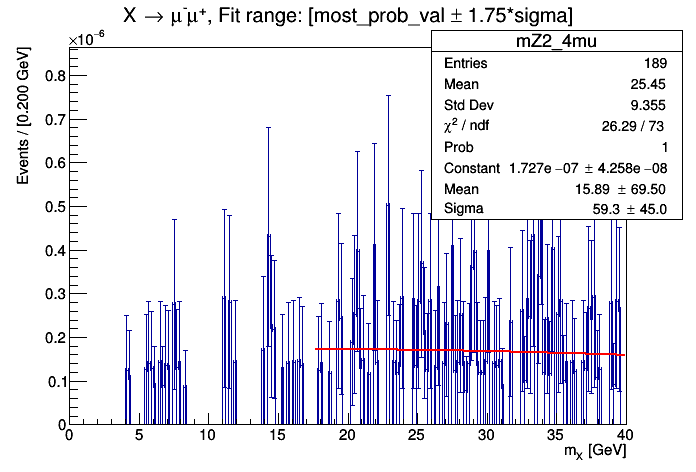

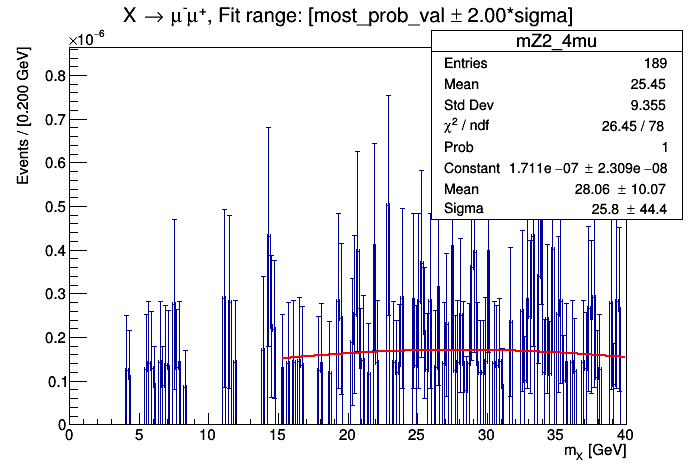

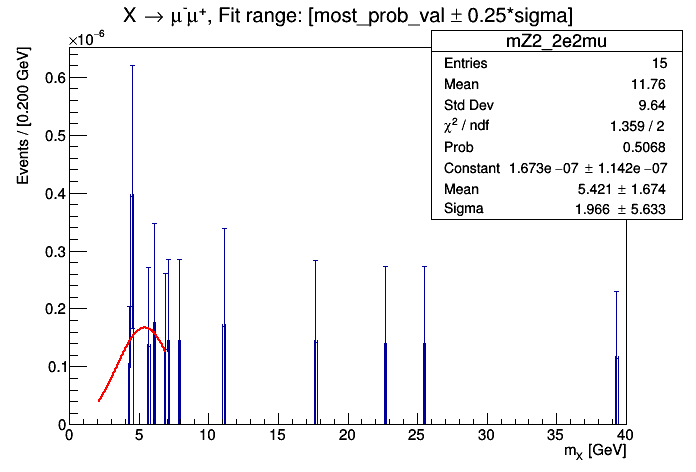

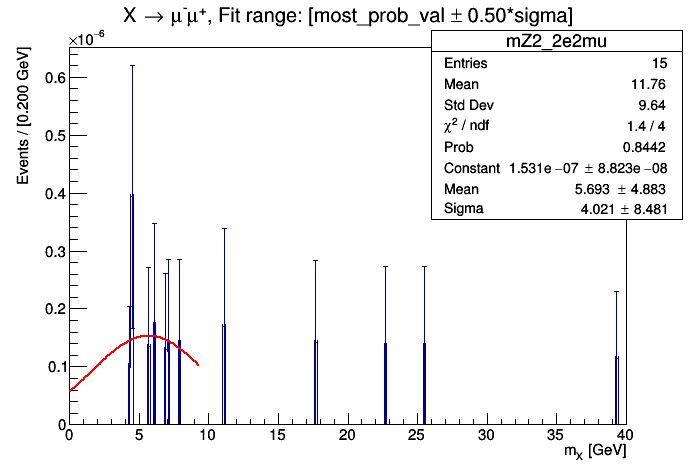

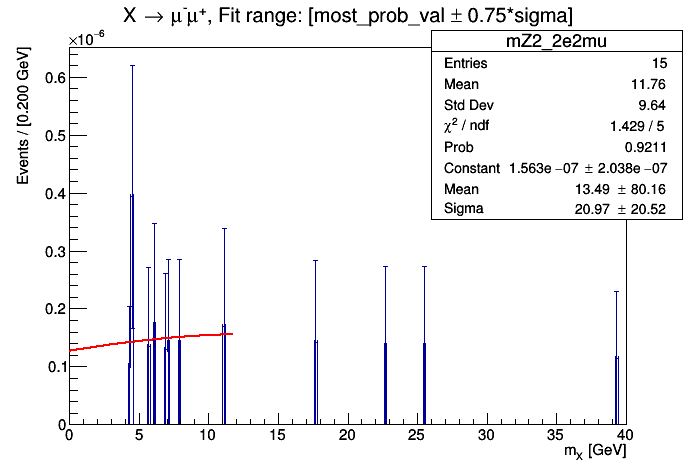

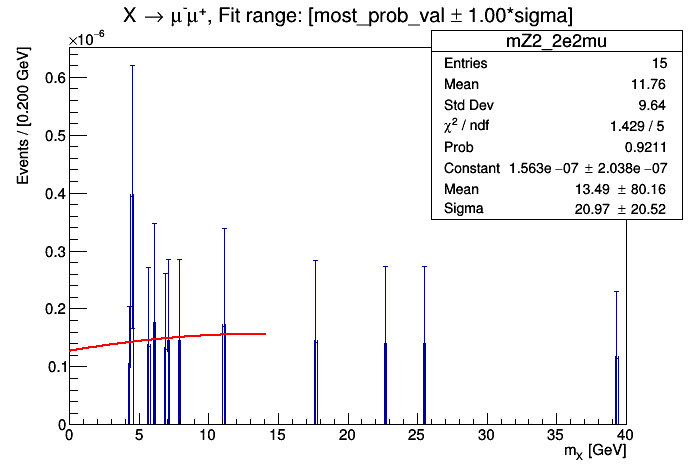

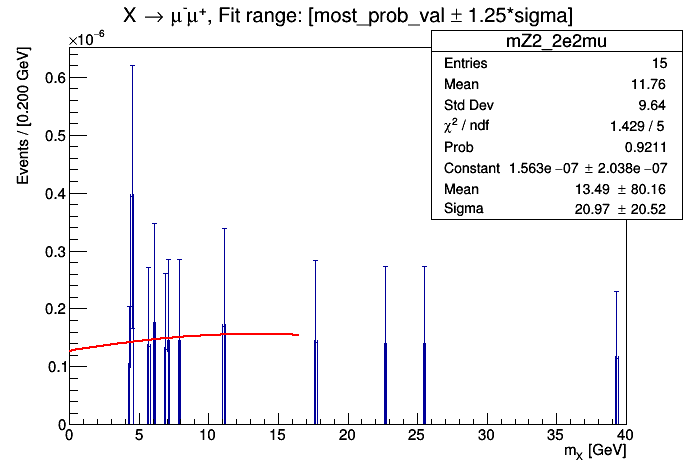

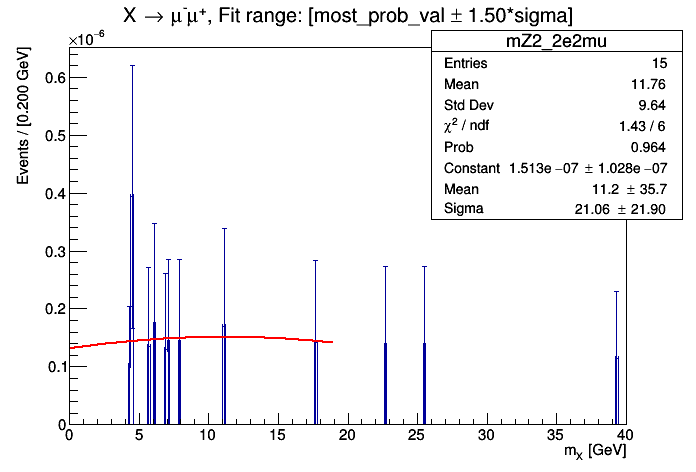

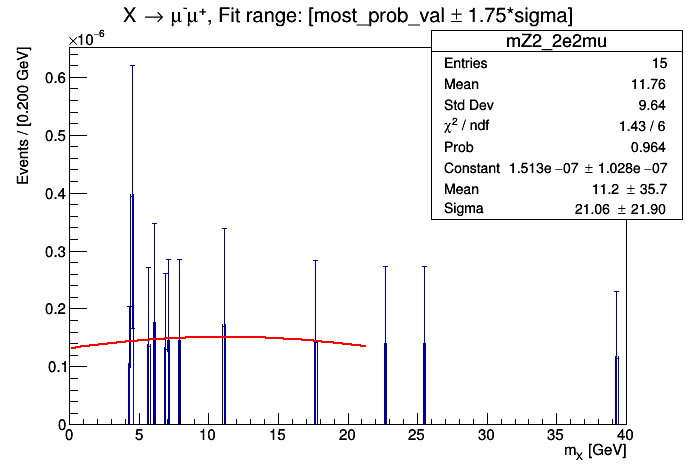

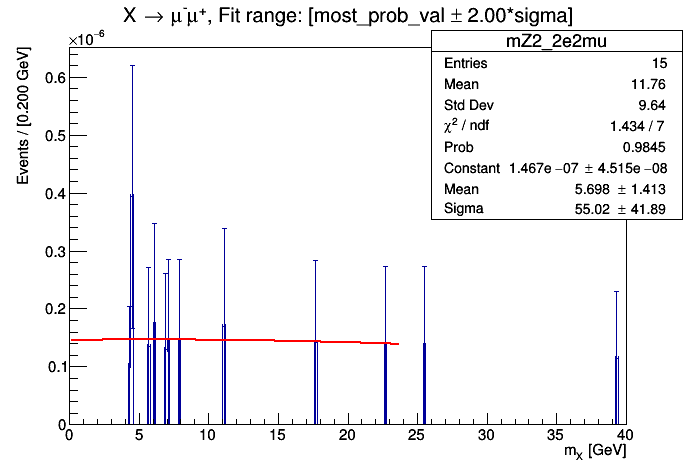

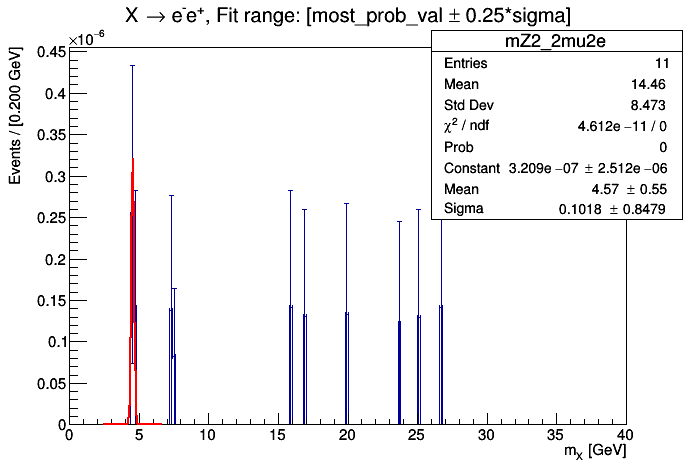

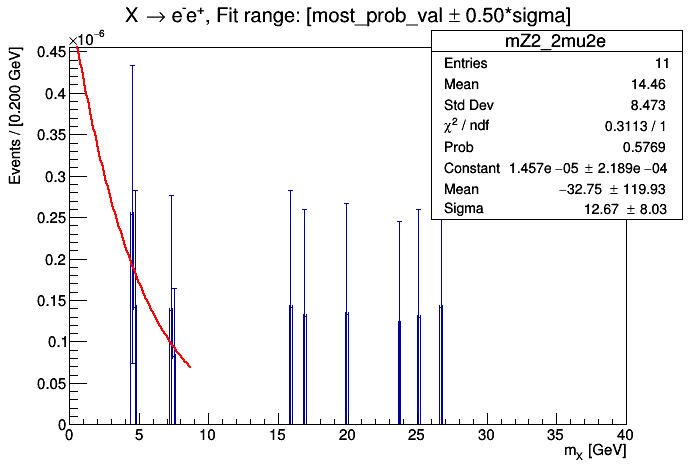

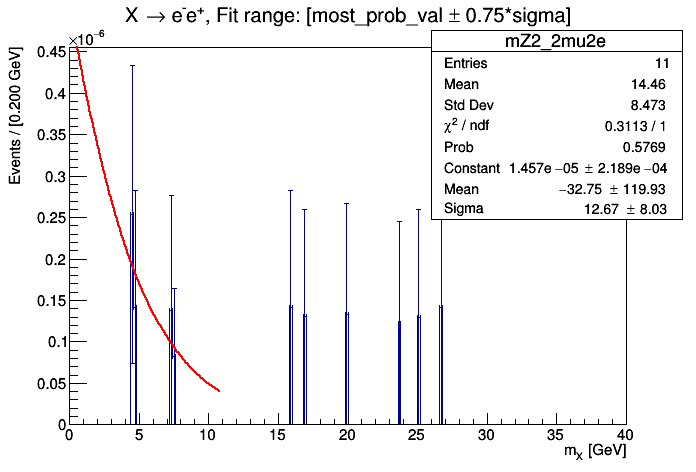

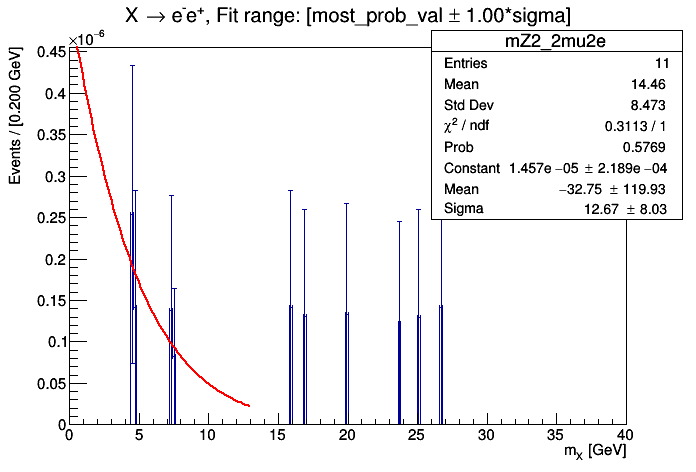

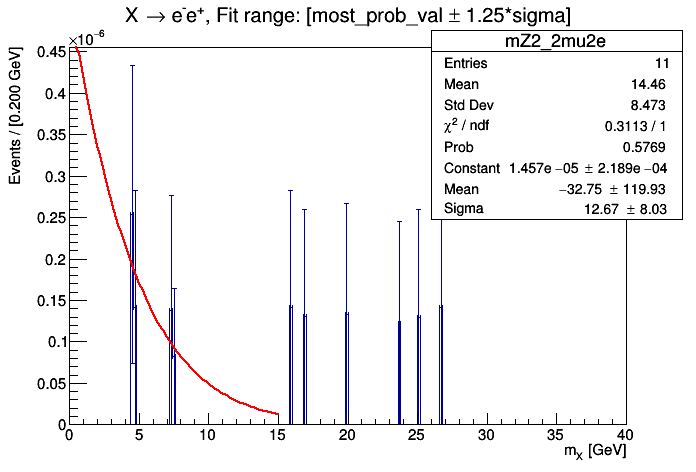

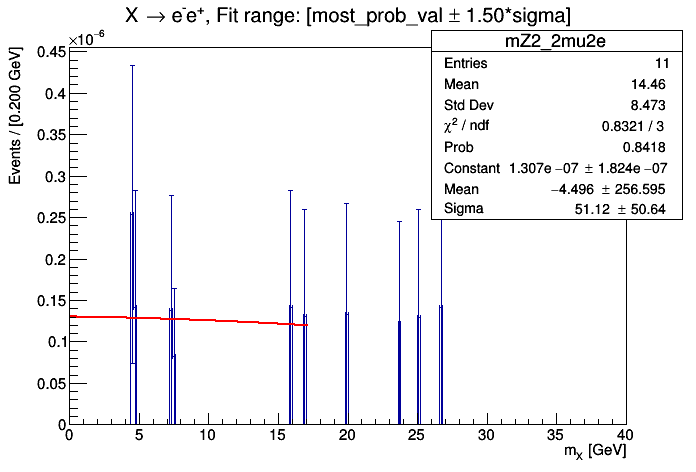

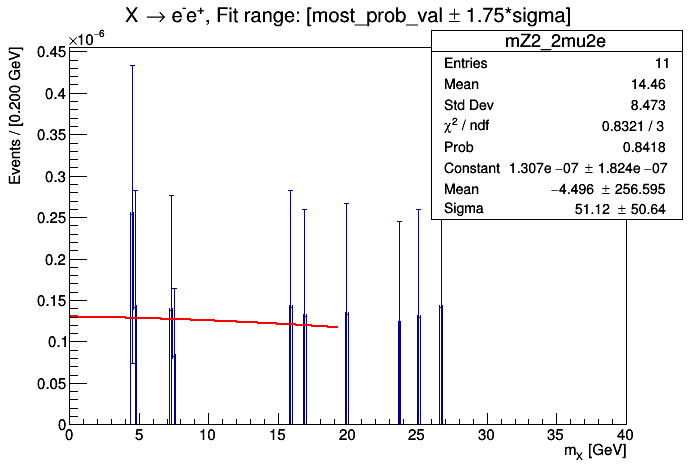

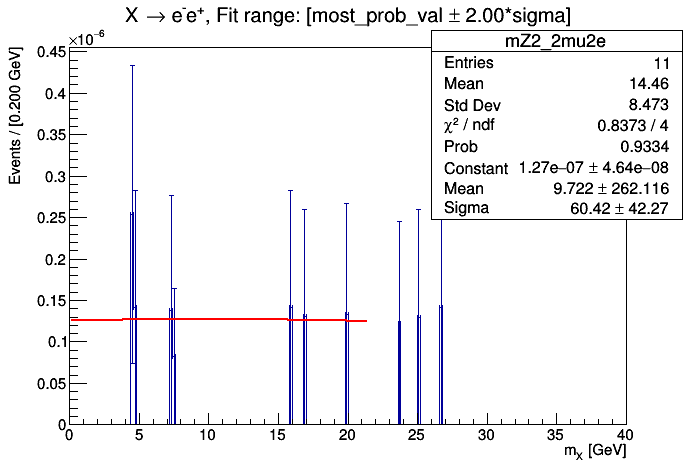

In [5]:
#----------------------------#
#----- Histo Collection -----#
#----------------------------#
# Make collection of histograms, one for each final state.
list_of_collections = [HistCollection(fs) for fs in fs_list]

for hcoll in list_of_collections:
    hcoll.mass_list = mass_list
    
for mass in mass_list:
    # For a given file, collect all the histograms.
    mass_str = str(mass)
    infile = infile_template.replace('__massval__',mass_str)
    print "Opening file:\n", infile
    f1 = TFile.Open(infile)

    # Make list of histos.
    for hcoll in list_of_collections:
        
        myhist = MyHist(hcoll.fs,mass_str,year)
        
        # Open and load real histogram.
        myhist.hist = f1.Get("mZ2_" + hcoll.fs)
        myhist.fit_with_gaus(n_stdev_list, draw=False, fit_around_mean=False)
        myhist.print_fit_info()
        myhist.save_plots(outpath_plots)
        myhist.get_best_fit_sigma(verbose=True)
        
        hcoll.hist_list.append( myhist )

# Test Cases:

In [201]:
# Open file
tmp_mass_str = str(mass_list[0])
infile = infile_template.replace('__massval__',tmp_mass_str)
print "Opening file:\n", infile
f1 = TFile.Open(infile)

h_4e = f1.Get("mZ2_4e")
h_2mu2e = f1.Get("mZ2_2mu2e")
h_4mu = f1.Get("mZ2_4mu")
h_2e2mu = f1.Get("mZ2_2e2mu")

# myhist_list = [MyHist(fs) for fs in fs_list]
myhist_4e = MyHist("4e",tmp_mass_str,"2016")
myhist_4e.hist = h_4e

Opening file:
/raid/raid7/rosedj1/Higgs/DarkZ/DarkPhotonSR/DataMCDistributions/HToZZd_Run2016_mXtoll_gausfit/HZZd_M15/DataMCDistribution.root


In [202]:
%%capture
myhist_4e.fit_with_gaus(n_stdev_list, draw=False, fit_around_mean=False)
myhist_4e.print_fit_info()
# myhist_4e.save_plots(outpath_plots)
myhist_4e.get_best_fit_sigma()

In [203]:
# print myhist_4e.red_chi2_list
print myhist_4e.fit_sigma_list
print myhist_4e.fit_sigma_err_list
print myhist_4e.n_dof_list
print myhist_4e.best_fit_sigma
print myhist_4e.best_fit_sigma_err
print myhist_4e.best_fit_rel_sigma
print myhist_4e.best_fit_rel_sigma_err
print "Looks like everything works!"

[0.350684934221946, 0.4372607124162872, 0.47949371052757195, 0.4828391478758966, 0.48302167164118626, 0.4830178451516721, 0.48302179214379287, 0.4830222077818269]
[0.01626522136381911, 0.009200077531839657, 0.010727726371393909, 0.011171471940687017, 0.011212909397041948, 0.011213355493615323, 0.011213481653342572, 0.011213600717440986]
[2, 8, 14, 18, 23, 29, 31, 34]
0.350684934222
0.0162652213638
0.0233789956148
0.00108434809092


In [ ]:
#-------------------------------------#
#----- Make rel. resolution plot -----#
#-------------------------------------#
n_pts = len(mass_list)
c1 = TCanvas()
c1.Draw()
#leg = TLegend(0.60,0.70,0.90,0.90)
leg = TLegend()

count = 1
graph_list = []

y_max_list = [max(hcoll.rel_sigma_list) for hcoll in list_of_collections]
y_max = max(y_max_list)
y_min = 0.0

for hcoll in list_of_collections:
    masses = np.array(hcoll.mass_list,dtype=float)
    rel_sigmas = np.array(hcoll.rel_sigma_list,dtype=float)
    rel_sigma_errs = np.array(hcoll.sigma_err_list,dtype=float)

    graph_list.append( TGraphErrors(n_pts, masses, rel_sigmas, np.zeros(n_pts), rel_sigma_errs) )
#    graph = TGraphErrors(n_pts, masses, rel_sigmas, np.zeros(n_pts), rel_sigma_errs)
#    graph.SetLineColor(count)
    graph_list[-1].SetMarkerStyle(count+19)  # 20=circle, 21=square, 22=tri, 23=upside down tri
    graph_list[-1].SetMarkerColor(count)
    graph_list[-1].SetMinimum(y_min)
    graph_list[-1].SetMaximum(y_max)
    graph_list[-1].SetTitle("Relative Resolution: X #rightarrow ll")
    graph_list[-1].GetXaxis().SetTitle("m_{X} [GeV]")
    graph_list[-1].GetYaxis().SetTitle("#sigma_{X}/m_{X}")
#    if 
#    graph.Draw("apl") if count == 1 else graph.Draw('pl same')
    graph_list[-1].Draw("apl") if count == 1 else graph_list[-1].Draw('pl same')
    X_fs = hcoll.X2_fs
    net_fs = hcoll.fs
    leg.AddEntry(graph_list[-1], "X #rightarrow %s (fs = %s)" % (X_fs,net_fs), "lpe")
    c1.Update()
#    c1.Draw()
    count += 1
leg.Draw("same")

#y_min = min(rel_sigmas*0.8)  # 1.2 just to catch the error bars.
#y_max = max(rel_sigmas*1.2)  # 1.2 just to catch the error bars.
#graph_list[-1].GetYaxis().SetLimits(y_min,y_max)
#c1.Update()

if (save_):
    c1.SaveAs(outpath_plots + graph_title + ".pdf")
    c1.SaveAs(outpath_plots + graph_title + ".png")

#        with open(outfile_params, "w") as f:
#            f.write(mass+'\t'+rel_sigma+'\n')

In [ ]:
c5 = TCanvas()
c5.Draw()
gStyle.SetOptStat(112210)
# gStyle.SetOptStat(1111)
tmp_hist = hist_ls[0]
tmp_hist.Draw()
statsbox = tmp_hist.FindObject("stats")
statsbox
# gStyle.SetStatX(0)
# gStyle.SetStatY(0)
# tmp_hist.Fit("gaus","SQ")
c5.Update()
c5.Draw()
# k = 1;  kurtosis printed
# k = 2;  kurtosis and kurtosis error printed
# s = 1;  skewness printed
# s = 2;  skewness and skewness error printed
# i = 1;  integral of bins printed
# i = 2;  integral of bins with option "width" printed
# o = 1;  number of overflows printed
# u = 1;  number of underflows printed
# r = 1;  standard deviation printed
# r = 2;  standard deviation and standard deviation error printed
# m = 1;  mean value printed
# m = 2;  mean and mean error values printed
# e = 1;  number of entries printed
# n = 1;  name of histogram is printed

In [ ]:
# for mass in mass_list:
#     tmp_infile = infile_template
#     f = TFile.Open( infile_template.replace("__massval__","%s")%str(mass) )
f = TFile.Open( infile_template.replace("__massval__","%s")%str(mass_list[0]) )

h = f.Get("mZ2_4e")
h.masspt = mass_list[0]
h.Rebin(2)
# c = TCanvas()

In [ ]:
h_tmp = hist_list[-1]
h_tmp.GetXaxis().GetBinCenter(h_tmp.GetMaximumBin())